In [1]:
import retro
from gym import Env
from gym.spaces import MultiBinary, Box, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt    

In [2]:
class StreetFighter(Env):
    def __init__(self,game_state='Champion.Level1.RyuVsGuile.state',record=False):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(2**12)
        self.total_matches_won = 0
        self.total_enemy_matches_won = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        self.record = record
        # if record:
        #     self.game = retro.make(game='StreetFighterII-Champion', record='.',state=game_state,use_restricted_actions=retro.Actions.DISCRETE)
        # else:
        self.game = retro.make(game='StreetFighterII-Champion', state=game_state,use_restricted_actions=retro.Actions.DISCRETE)


    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs_orig = obs
        obs = self.preprocess(obs)
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        if self.prev_matches_won > info['matches_won']:
            self.prev_matches_won = info['matches_won']
        if self.prev_enemy_matches_won > info['enemy_matches_won']:
            self.prev_enemy_matches_won = info['enemy_matches_won']
        self.total_matches_won = self.total_matches_won + info['matches_won'] - self.prev_matches_won
        self.total_enemy_matches_won = self.total_enemy_matches_won + info['enemy_matches_won'] - self.prev_enemy_matches_won
        self.prev_matches_won = info['matches_won']
        self.prev_enemy_matches_won = info['enemy_matches_won']
        reward = info['score'] - self.score
        self.score = info['score']
        self.obs_orig = obs_orig
        return frame_delta, reward, done, info
        
    def get_obs_orig(self):
        return self.obs_orig

    def render(self,*args,**kwargs):
        self.game.render()

    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.score = 0
        self.prev_matches_won = 0
        self.prev_enemy_matches_won = 0
        return obs

    def preprocess(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), cv2.INTER_CUBIC)
        channels = np.reshape(resize, (84,84,1))
        return channels

    def close(self):
        self.game.close()

In [147]:
env.close()

In [4]:
env = StreetFighter(game_state='Champion.Level1.Chun-LiVsDhalsim.state')

In [5]:
obs = env.reset()
action = env.action_space.sample()
while True:
    state, reward, done, info = env.step(action)
    # if reward != 0:
    #     print(reward)
    #     print(info)
    env.render()
    if done:
        break
    action = env.action_space.sample()
env.close()

c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


In [6]:
import optuna
import os
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
LOG_DIR = './logs/DQN/Chun-Li'
OPT_DIR = './opt/DQN/Chun-Li'
CHECKPOINT_DIR = './train/DQN/Chun-Li'

In [8]:
def optimize(trial):
    return {
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-5,1e-4),
        'gamma':trial.suggest_loguniform('gamma', 0.8,0.9999),
        'tau':trial.suggest_loguniform('tau', 0.001,0.01),
    }

In [9]:
env.close()

In [9]:
def optimize_agent(trial):
    try:
        model_params = optimize(trial)
        env = StreetFighter(game_state='Champion.Level1.Chun-LiVsDhalsim.state')
        env = Monitor(env,LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env,4,channels_order='last')

        model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=0,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
        model.learn(total_timesteps=10000)

        mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=10)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        print(mean_reward)
        
        return mean_reward
    except Exception as e:
        print(e)
        return -1000

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent,n_trials=10,n_jobs=1)

[I 2024-04-25 00:47:46,353] A new study created in memory with name: no-name-c48c3e99-cabc-4c69-a4ca-7aa6e9db8402
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  after removing the cwd from sys.path.
c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

25800.0


[I 2024-04-25 01:03:18,192] Trial 1 finished with value: 14300.0 and parameters: {'learning_rate': 2.4451880911973988e-05, 'gamma': 0.8196584178937547, 'tau': 0.005184327332132177}. Best is trial 0 with value: 25800.0.


14300.0


[I 2024-04-25 01:09:06,909] Trial 2 finished with value: 5000.0 and parameters: {'learning_rate': 2.4188270943251677e-05, 'gamma': 0.9387053205851688, 'tau': 0.004077530947446545}. Best is trial 0 with value: 25800.0.


5000.0


[I 2024-04-25 01:18:25,370] Trial 3 finished with value: 37700.0 and parameters: {'learning_rate': 1.6687767968147328e-05, 'gamma': 0.9006227850493569, 'tau': 0.004357598835318333}. Best is trial 3 with value: 37700.0.


37700.0


[I 2024-04-25 01:25:28,786] Trial 4 finished with value: 10500.0 and parameters: {'learning_rate': 2.3547555244747854e-05, 'gamma': 0.9723085348778504, 'tau': 0.002009424983738764}. Best is trial 3 with value: 37700.0.


10500.0


[I 2024-04-25 01:29:07,083] Trial 5 finished with value: 2900.0 and parameters: {'learning_rate': 6.962667543717265e-05, 'gamma': 0.8379968344178078, 'tau': 0.0014708653621579295}. Best is trial 3 with value: 37700.0.


2900.0


[I 2024-04-25 01:39:33,033] Trial 6 finished with value: 23200.0 and parameters: {'learning_rate': 3.4680664060177655e-05, 'gamma': 0.8990402541027979, 'tau': 0.00981471716203836}. Best is trial 3 with value: 37700.0.


23200.0


[I 2024-04-25 01:49:29,283] Trial 7 finished with value: 19300.0 and parameters: {'learning_rate': 7.712777331150607e-05, 'gamma': 0.8367263730159661, 'tau': 0.003464971855927796}. Best is trial 3 with value: 37700.0.


19300.0


[I 2024-04-25 01:59:40,859] Trial 8 finished with value: 33000.0 and parameters: {'learning_rate': 1.3005758616694313e-05, 'gamma': 0.9756536005843028, 'tau': 0.001546442436689417}. Best is trial 3 with value: 37700.0.


33000.0


[I 2024-04-25 02:10:28,642] Trial 9 finished with value: 28000.0 and parameters: {'learning_rate': 7.831093685676595e-05, 'gamma': 0.8344501332737503, 'tau': 0.0010387106141507203}. Best is trial 3 with value: 37700.0.


28000.0


In [11]:
study.best_trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[37700.0], datetime_start=datetime.datetime(2024, 4, 25, 1, 9, 6, 910912), datetime_complete=datetime.datetime(2024, 4, 25, 1, 18, 25, 370178), params={'learning_rate': 1.6687767968147328e-05, 'gamma': 0.9006227850493569, 'tau': 0.004357598835318333}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'tau': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, trial_id=3, value=None)

In [12]:
study.best_params

{'learning_rate': 1.6687767968147328e-05,
 'gamma': 0.9006227850493569,
 'tau': 0.004357598835318333}

In [13]:
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}_'.format(self.n_calls))
            self.model.save(model_path)
            self.logger.record('matches_won', self.training_env.get_attr('total_matches_won')[0])
            self.logger.record('enemy_matches_won', self.training_env.get_attr('total_enemy_matches_won')[0])

        return True

In [15]:
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECKPOINT_DIR)

In [25]:
env.close()

In [16]:
env = StreetFighter(game_state='Champion.Level1.Chun-LiVsDhalsim.state')
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [17]:
model_params = {}
model_params['learning_rate'] = 1.6687767968147328e-05
model_params['gamma'] = 0.9006227850493569
model_params['tau'] = 0.004357598835318333

In [18]:
model = DQN("CnnPolicy",env,tensorboard_log=LOG_DIR,verbose=2,batch_size=256,buffer_size=80000, **model_params) # cnn policy uses conv neural net for 
# model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))
model.load(os.path.join(OPT_DIR, 'trial_3_best_model.zip'))
model.learn(total_timesteps=1000000,callback=callback)
# can increase training time and learning rate later

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/DQN/Chun-Li\DQN_11
----------------------------------
| enemy_matches_won   | 8        |
| matches_won         | 6        |
| rollout/            |          |
|    ep_len_mean      | 1.29e+04 |
|    ep_rew_mean      | 1.89e+04 |
|    exploration_rate | 0.51     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 302      |
|    time_elapsed     | 170      |
|    total_timesteps  | 51602    |
| train/              |          |
|    learning_rate    | 1.67e-05 |
|    loss             | 1.95     |
|    n_updates        | 400      |
----------------------------------
----------------------------------
| enemy_matches_won   | 15       |
| matches_won         | 10       |
| rollout/            |          |
|    ep_len_mean      | 1.25e+04 |
|    ep_rew_mean      | 1.59e+04 |
|    exploration_rate | 0.0518   |
| time/               |          |
|    episodes         | 8     

In [30]:
env.close()

In [22]:
env = StreetFighter(game_state='Champion.Level1.Chun-LiVsDhalsim.state')
env = Monitor(env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

In [25]:
model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_50000_'))
# Ken best (steps - reward) 1000000 - 1400,  50000 - 3300
# Guile best (steps - reward) 1000000 - 2700, 
# Zangief best (steps - reward) 1000000 - 18400, 58000 - 10300
# Chun-Li best (steps - reward) 1000000 - 23200, 500000 - 16900, 50000 = 11400
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=5)
print(mean_reward)

11400.0


In [26]:
from matplotlib import animation
import matplotlib.pyplot as plt

In [27]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=180)

In [28]:
my_env.close()

NameError: name 'my_env' is not defined

MovieWriter imagemagick unavailable; using Pillow instead.
Exception ignored in: <function SimpleImageViewer.__del__ at 0x00000208BA2491F8>
Traceback (most recent call last):
  File "c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\gym\envs\classic_control\rendering.py", line 458, in __del__
    self.close()
  File "c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\gym\envs\classic_control\rendering.py", line 454, in close
    self.window.close()
  File "c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\pyglet\window\win32\__init__.py", line 313, in close
    super(Win32Window, self).close()
  File "c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "c:\Users\reece\anaconda3\envs\streetfighter37_copy3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x0000020881E37C28; to 'Win32W

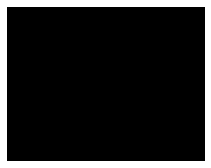

In [31]:
"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""

#Make gym env
my_env = StreetFighter(game_state='Champion.Level1.Chun-LiVsDhalsim.state')
env = Monitor(my_env,LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env,4,channels_order='last')

model = DQN.load(os.path.join(CHECKPOINT_DIR, 'best_model_1000000_'))
obs = env.reset()
done = False
frames = []

while not done:
    if done:
        break
    # frames.append(env.render(mode="rgb_array"))
    env.render()
    obs,reward,done,info = env.step(model.predict(obs)[0])
    rec_obs = my_env.get_obs_orig()
    frames.append(rec_obs)
env.close()

save_frames_as_gif(frames)